In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import LabelEncoder
from sklearn.linear_model import LinearRegression


### Import data

In [11]:
originalDataX = pd.read_csv('data/Data_X.csv')
originalDataY = pd.read_csv('data/Data_Y.csv')
originalDataNew = pd.read_csv('data/DataNew_X.csv')

In [12]:
# Merge X and Y

df = pd.merge(originalDataX, originalDataY, on='ID')


### Data Preparation


In [13]:
# Remove unnecessary columns

df = df.drop(['ID'], axis=1)

In [14]:
# Remove duplicated values
df = df.drop_duplicates()
print(df.duplicated().sum())

0


In [15]:
# Label encoding

le = LabelEncoder()
le.fit(['FR', 'DE'])
df['COUNTRY'] = le.transform(df['COUNTRY'])


print(df.head())

   DAY_ID  COUNTRY  DE_CONSUMPTION  FR_CONSUMPTION  DE_FR_EXCHANGE   
0     206        1        0.210099       -0.427458       -0.606523  \
1     501        1       -0.022399       -1.003452       -0.022063   
2     687        1        1.395035        1.978665        1.021305   
3     720        0       -0.983324       -0.849198       -0.839586   
4     818        1        0.143807       -0.617038       -0.924990   

   FR_DE_EXCHANGE  DE_NET_EXPORT  FR_NET_EXPORT  DE_NET_IMPORT  FR_NET_IMPORT   
0        0.606523            NaN       0.692860            NaN      -0.692860  \
1        0.022063      -0.573520      -1.130838       0.573520       1.130838   
2       -1.021305      -0.622021      -1.682587       0.622021       1.682587   
3        0.839586      -0.270870       0.563230       0.270870      -0.563230   
4        0.924990            NaN       0.990324            NaN      -0.990324   

   ...   DE_RAIN   FR_RAIN   DE_WIND   FR_WIND   DE_TEMP   FR_TEMP   GAS_RET   
0  ... -0.17

### Data Exploration

In [16]:
# List columns
print(df.columns)

Index(['DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION',
       'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT',
       'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET',
       'TARGET'],
      dtype='object')


In [ ]:
# Describe data
print(df.describe())

In [17]:
# Variance
print(df.var())

DAY_ID              119069.883670
COUNTRY                  0.245318
DE_CONSUMPTION           0.453483
FR_CONSUMPTION           0.844552
DE_FR_EXCHANGE           0.941338
FR_DE_EXCHANGE           0.941338
DE_NET_EXPORT            0.916697
FR_NET_EXPORT            1.157411
DE_NET_IMPORT            0.916697
FR_NET_IMPORT            1.157411
DE_GAS                   0.722823
FR_GAS                   0.821742
DE_COAL                  0.717892
FR_COAL                  0.256179
DE_HYDRO                 1.180113
FR_HYDRO                 1.119082
DE_NUCLEAR               0.814449
FR_NUCLEAR               0.930343
DE_SOLAR                 1.144683
FR_SOLAR                 1.165100
DE_WINDPOW               1.132494
FR_WINDPOW               1.414682
DE_LIGNITE               0.724778
DE_RESIDUAL_LOAD         0.725051
FR_RESIDUAL_LOAD         0.803398
DE_RAIN                  0.968714
FR_RAIN                  1.106243
DE_WIND                  1.115650
FR_WIND                  1.112374
DE_TEMP       

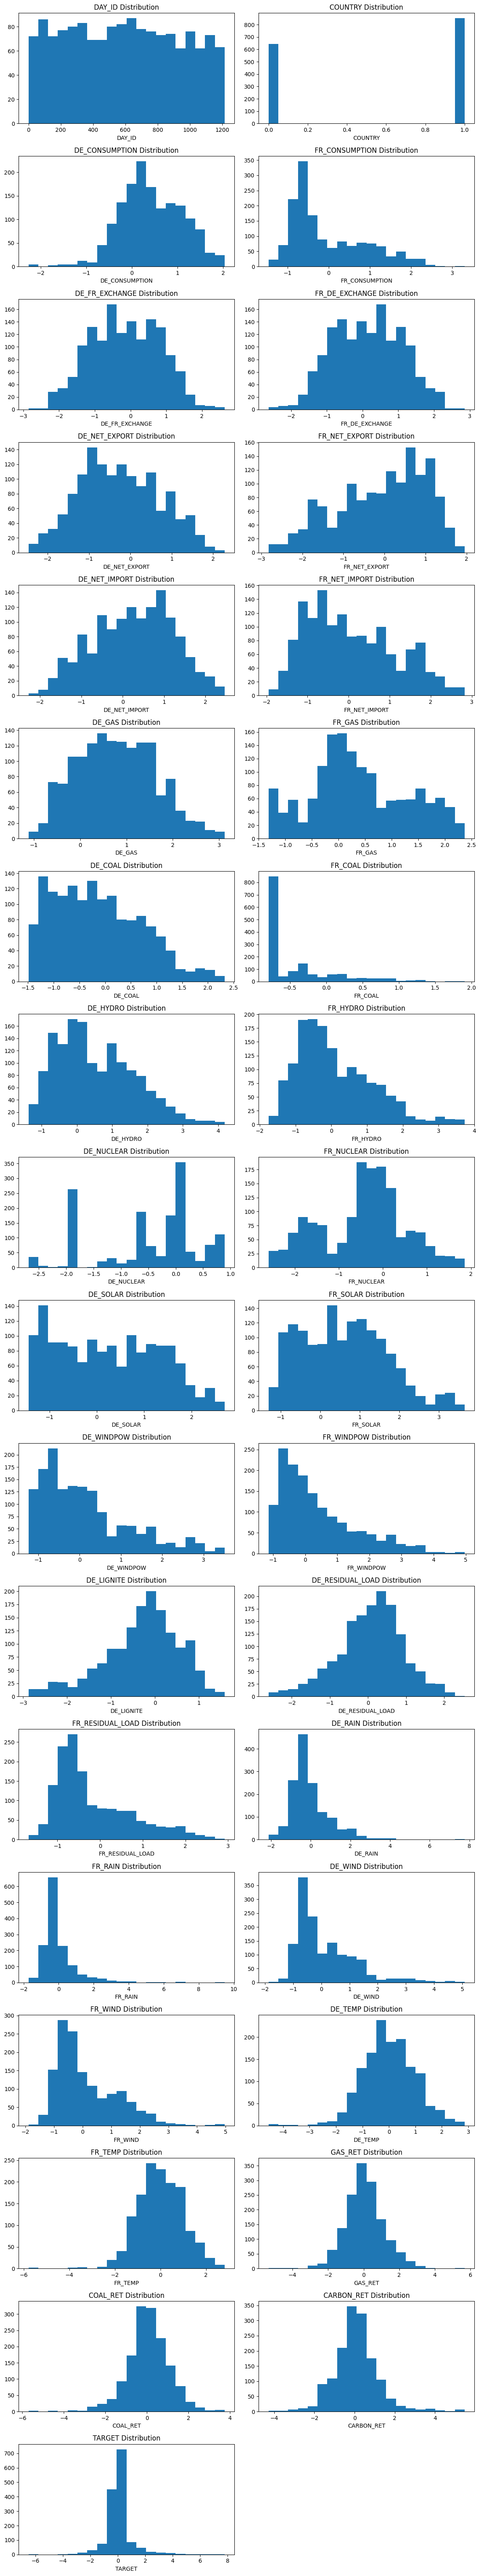

In [18]:
#Plot repartition of the data

plt.figure(figsize=(12,64))

for i, j in enumerate(df.columns):
    plt.subplot(18,2, i+1)
    # Histogram
    plt.hist(df[j], bins=20)
    plt.xlabel(j)
    plt.title('{} Distribution'.format(j))
    plt.subplots_adjust(wspace=.2, hspace=.5)
    plt.tight_layout()
plt.show()

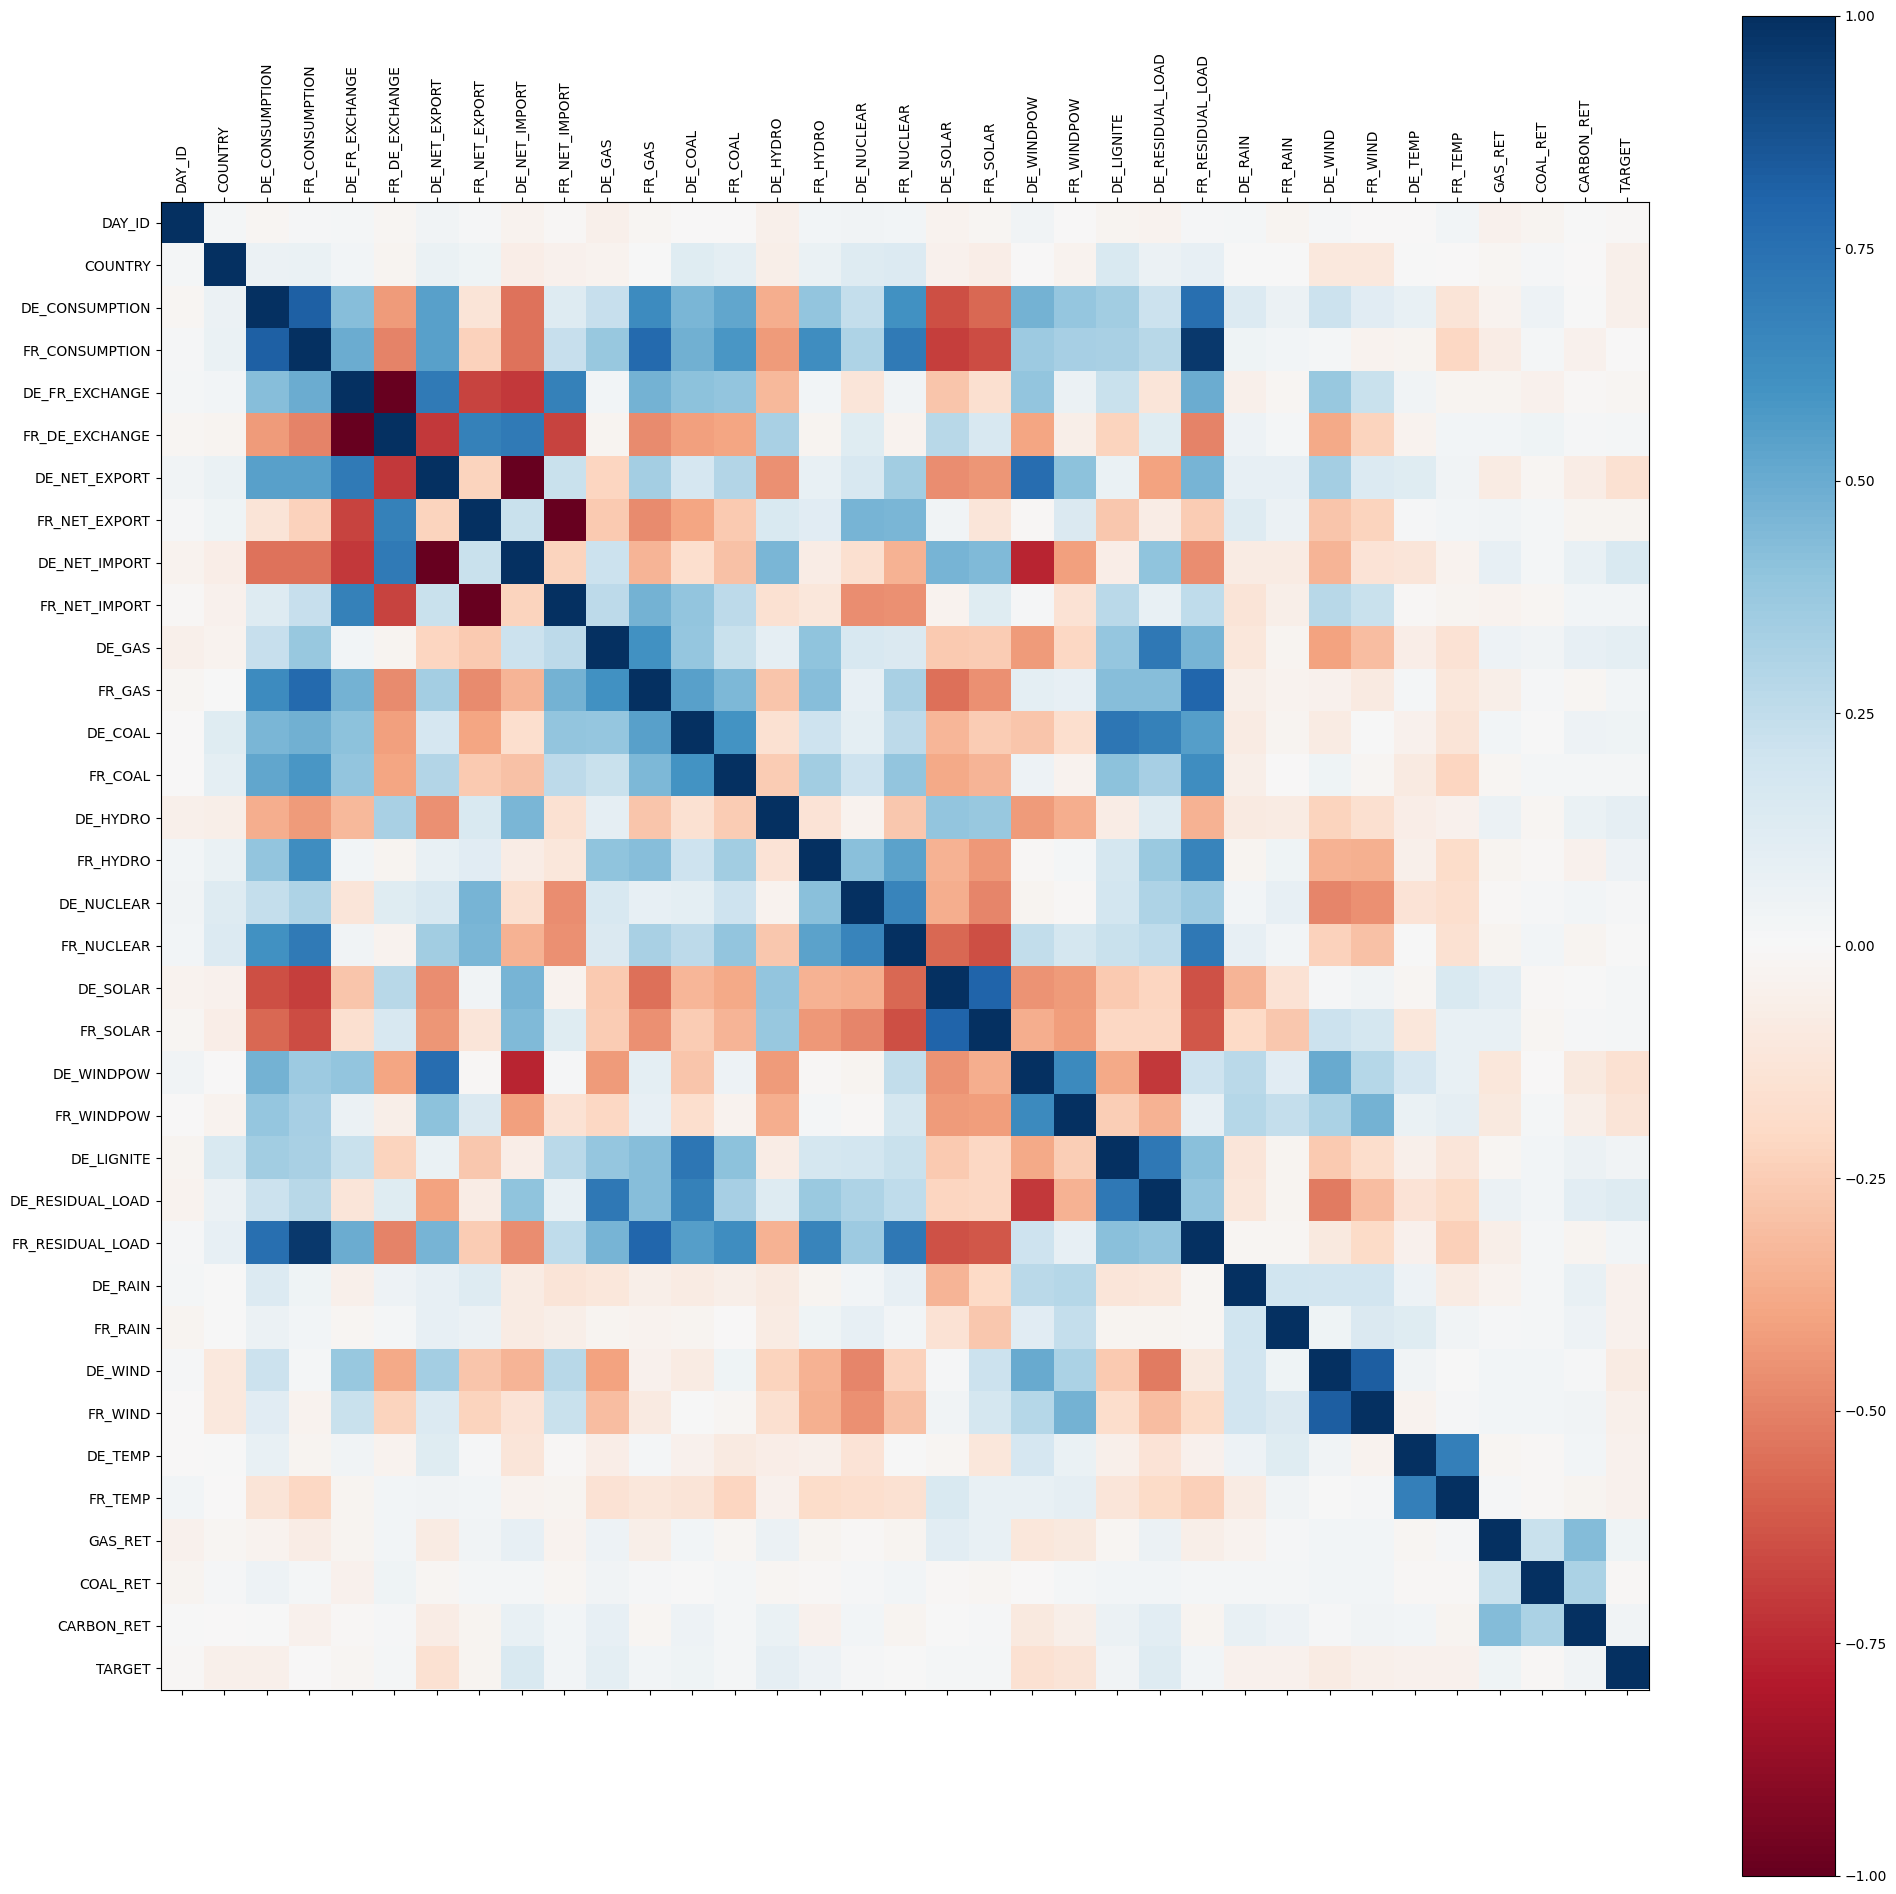

In [26]:
# Plot correlation matrix with heatmap

corr = df.corr()

plt.figure(figsize=(24, 24))
plt.matshow(corr, fignum=1, cmap='RdBu')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

In [19]:
# Print each column correlation with each other
treashold = 0.75
variable_seen = []

for i in df.columns:
    for j in df.columns:
        if (i, j) not in variable_seen:
            variable_seen += [(j, i)]
            if i != j and df[i].corr(df[j]) > treashold or df[i].corr(df[j]) < -treashold :
                print("{:>20} <--> {:<20} :  {}".format(i, j, df[i].corr(df[j])))


      DE_CONSUMPTION <--> FR_CONSUMPTION       :  0.8132017057921077
      DE_CONSUMPTION <--> FR_RESIDUAL_LOAD     :  0.7541421978532984
      FR_CONSUMPTION <--> FR_GAS               :  0.7797271465379936
      FR_CONSUMPTION <--> FR_RESIDUAL_LOAD     :  0.9650862507900642
      DE_FR_EXCHANGE <--> FR_DE_EXCHANGE       :  -1.0
       DE_NET_EXPORT <--> DE_NET_IMPORT        :  -1.0
       DE_NET_EXPORT <--> DE_WINDPOW           :  0.7633981271837321
       FR_NET_EXPORT <--> FR_NET_IMPORT        :  -0.9999999999999998
       DE_NET_IMPORT <--> DE_WINDPOW           :  -0.7633981271837321
              FR_GAS <--> FR_RESIDUAL_LOAD     :  0.7959142919276712
            DE_SOLAR <--> FR_SOLAR             :  0.8033807850273869
             DE_WIND <--> FR_WIND              :  0.8207241242953597


##### Interpretation of correlations

What we can deduce is that the french and german's consumption is extremely linked, with a correlation of 80%.
We can also see that the french consumption is linked to the gas consumption at 78%, so french electricity depends on gas a lot.
The more the french consumption augments, the more they use the residual load, because there aren't enough renewable energies. We can also see that the residual load is mostly constitued by gas.
Germans export a lot of wind energy.

When french's solar energy is high, the german's solar energy is high too, most likely because the two countries are close and subject to the same weather conditions.

### Data Analysis

In [20]:
# linear regression
X = df.drop('TARGET', axis=1)
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_test)

print('Coefficients: \n', reg.coef_)
# Print coefficient for each variable
for i, j in enumerate(X.columns):
    print("{} : {}".format(j, reg.coef_[i]))

print('Intercept: \n', reg.intercept_)
print('Mean squared error: %.2f' % np.mean((y_pred - y_test) ** 2))  
print('Coefficient of determination: %.2f' % reg.score(X_test, y_test))

# Plot outputs
plt.figure(figsize=(12,64))

for i, j in enumerate(X.columns):
    plt.subplot(18,2, i+1)
    plt.scatter(X_test[j], y_test,  color='black')
    plt.plot(X_test[j], y_pred, color='blue', linewidth=1)
    plt.xlabel(j)
    plt.title(j)
    plt.subplots_adjust(wspace=.2, hspace=.5)
    plt.tight_layout()

# plt.scatter(X_test['FR_NET_EXPORT'], y_test,  color='black')
# plt.plot(X_test['FR_NET_EXPORT'], y_pred, color='blue', linewidth=1)
# plt.show()


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values